# ESP32 Custom Voice Training and Validation

Train a wake word detection model from your voice samples and validate its effectiveness for ESP32 deployment.

In [29]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import subprocess

# Add parent directory to path
sys.path.insert(0, os.path.abspath('..'))

print("✓ Setup complete!")
print(f"Working directory: {os.getcwd()}")
print(f"Voice samples directory: ../voice_samples/")

✓ Setup complete!
Working directory: /home/sprchuoi/sandboxes/openWakeWord/notebooks
Voice samples directory: ../voice_samples/


## 1. Load and Analyze Voice Samples

First, let's examine your recorded voice samples.

In [30]:
# Find all voice samples
voice_dir = Path('../voice_samples')
wav_files = sorted(list(voice_dir.glob('*.wav')))

print(f"Found {len(wav_files)} voice samples")
print("\nFirst 10 samples:")
for i, f in enumerate(wav_files[:10]):
    size_kb = f.stat().st_size / 1024
    print(f"  {i+1:2d}. {f.name:30s} ({size_kb:.1f} KB)")

if len(wav_files) > 10:
    print(f"  ... and {len(wav_files) - 10} more")

# Calculate energies for analysis
energies = []
for wav_file in wav_files:
    try:
        with open(wav_file, 'rb') as f:
            f.seek(44)  # Skip WAV header
            data = f.read()
            samples = np.frombuffer(data, dtype=np.int16)
            energy = np.sqrt(np.mean(samples.astype(float) ** 2))
            energies.append(energy)
    except Exception as e:
        print(f"Error reading {wav_file.name}: {e}")

print(f"\n✓ Successfully analyzed {len(energies)} samples")

Found 32 voice samples

First 10 samples:
   1. hey_assistant_000.wav          (62.5 KB)
   2. hey_assistant_001.wav          (62.5 KB)
   3. hey_assistant_002.wav          (62.5 KB)
   4. hey_assistant_003.wav          (62.5 KB)
   5. hey_assistant_004.wav          (62.5 KB)
   6. hey_assistant_005.wav          (62.5 KB)
   7. hey_assistant_006.wav          (62.5 KB)
   8. hey_assistant_007.wav          (62.5 KB)
   9. hey_assistant_008.wav          (62.5 KB)
  10. hey_assistant_009.wav          (62.5 KB)
  ... and 22 more

✓ Successfully analyzed 32 samples


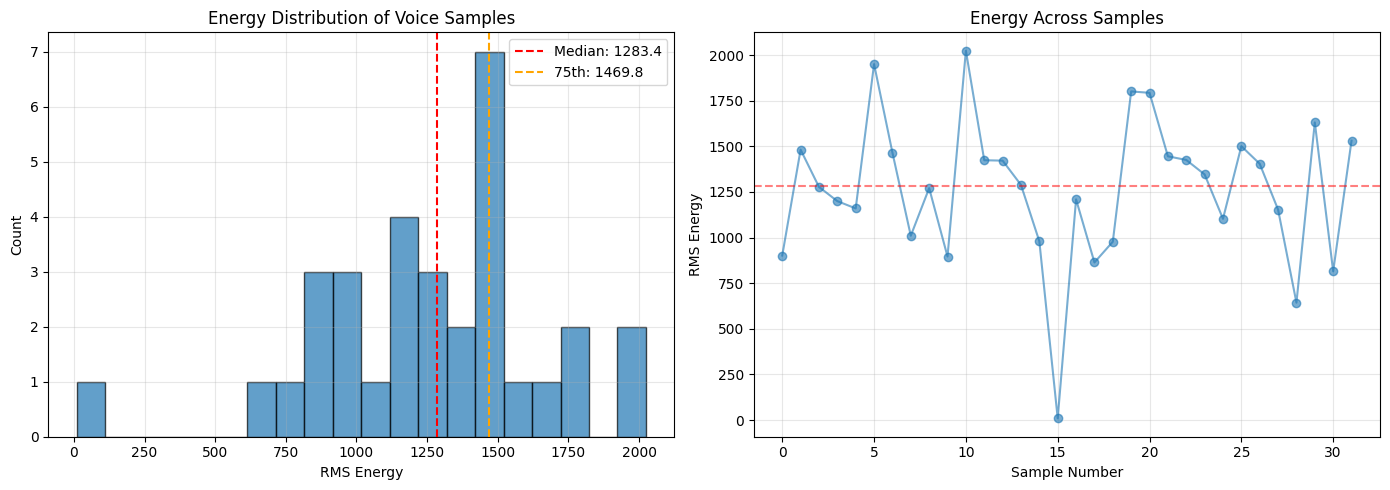


Energy Statistics:
  Mean:   1262.80
  Median: 1283.36
  Std:    394.32
  Range:  9.62 - 2024.19
  50th percentile: 1283.36
  75th percentile: 1469.84
  95th percentile: 1868.40


In [31]:
# Visualize energy distribution
plt.figure(figsize=(14, 5))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(energies, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('RMS Energy')
plt.ylabel('Count')
plt.title('Energy Distribution of Voice Samples')
plt.axvline(np.median(energies), color='r', linestyle='--', label=f'Median: {np.median(energies):.1f}')
plt.axvline(np.percentile(energies, 75), color='orange', linestyle='--', label=f'75th: {np.percentile(energies, 75):.1f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Energy per sample
plt.subplot(1, 2, 2)
plt.plot(energies, marker='o', linestyle='-', alpha=0.6)
plt.xlabel('Sample Number')
plt.ylabel('RMS Energy')
plt.title('Energy Across Samples')
plt.axhline(np.median(energies), color='r', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nEnergy Statistics:")
print(f"  Mean:   {np.mean(energies):.2f}")
print(f"  Median: {np.median(energies):.2f}")
print(f"  Std:    {np.std(energies):.2f}")
print(f"  Range:  {np.min(energies):.2f} - {np.max(energies):.2f}")
print(f"  50th percentile: {np.percentile(energies, 50):.2f}")
print(f"  75th percentile: {np.percentile(energies, 75):.2f}")
print(f"  95th percentile: {np.percentile(energies, 95):.2f}")

## 2. Option A: Train Simple Energy-Based Model (Fast, No ML)

For quick prototyping without ML training. Uses RMS energy thresholding.

In [32]:
# Train model with 75th percentile threshold (balanced)
wake_word = "hey_assistant"
threshold_percentile = 75

print(f"Training model: {wake_word}")
print(f"Threshold percentile: {threshold_percentile}")
print(f"Training samples: {len(wav_files)}\n")

# Calculate threshold
threshold = np.percentile(energies, threshold_percentile)
print(f"Calculated threshold: {threshold:.2f}")

# Generate model header file
output_file = f"{wake_word}_model.h"

# Sanitize wake word for C identifier
model_name = wake_word.replace(' ', '_').replace('-', '_')
model_name_upper = model_name.upper()

# Generate C code
c_code = f'''/*
 * Wake Word Detection Model: {wake_word}
 * Generated from {len(wav_files)} training samples
 * Threshold: {threshold:.2f} (at {threshold_percentile}th percentile)
 */

#ifndef {model_name_upper}_MODEL_H
#define {model_name_upper}_MODEL_H

#include <stdint.h>
#include <stdbool.h>
#include <math.h>

#define {model_name_upper}_THRESHOLD {threshold:.2f}f
#define {model_name_upper}_SAMPLE_RATE 16000
#define {model_name_upper}_FRAME_SIZE 1280

typedef struct {{
    float threshold;
    float last_energy;
    uint32_t detection_count;
    uint32_t frame_count;
}} {model_name}_model_t;

static inline void {model_name}_init({model_name}_model_t* model) {{
    model->threshold = {model_name_upper}_THRESHOLD;
    model->last_energy = 0.0f;
    model->detection_count = 0;
    model->frame_count = 0;
}}

static inline float {model_name}_calculate_energy(const int16_t* audio_data, size_t length) {{
    float sum = 0.0f;
    for (size_t i = 0; i < length; i++) {{
        float sample = (float)audio_data[i];
        sum += sample * sample;
    }}
    return sqrtf(sum / length);
}}

static inline bool {model_name}_predict({model_name}_model_t* model, 
                                        const int16_t* audio_data, 
                                        size_t length,
                                        float* confidence) {{
    float energy = {model_name}_calculate_energy(audio_data, length);
    model->last_energy = energy;
    model->frame_count++;
    
    bool detected = (energy > model->threshold);
    *confidence = energy / (model->threshold * 2.0f);
    if (*confidence > 1.0f) *confidence = 1.0f;
    
    if (detected) model->detection_count++;
    return detected;
}}

static inline void {model_name}_set_threshold({model_name}_model_t* model, float new_threshold) {{
    model->threshold = new_threshold;
}}

#endif // {model_name_upper}_MODEL_H
'''

# Save model file
with open(output_file, 'w') as f:
    f.write(c_code)

print(f"\n✓ Model saved to: {output_file}")
print(f"✓ Model is ready for ESP32 deployment!")

Training model: hey_assistant
Threshold percentile: 75
Training samples: 32

Calculated threshold: 1469.84

✓ Model saved to: hey_assistant_model.h
✓ Model is ready for ESP32 deployment!


## 3. Validate Model on Training Samples

Test the model on the voice samples used for training.

In [33]:
# Simulate model prediction on each sample
FRAME_SIZE = 1280

results = []
for wav_file in wav_files:
    with open(wav_file, 'rb') as f:
        f.seek(44)
        data = f.read()
        samples = np.frombuffer(data, dtype=np.int16)
    
    # Process in frames
    detections = 0
    total_frames = 0
    max_energy = 0
    
    for i in range(0, len(samples) - FRAME_SIZE, FRAME_SIZE):
        frame = samples[i:i+FRAME_SIZE]
        energy = np.sqrt(np.mean(frame.astype(float) ** 2))
        max_energy = max(max_energy, energy)
        total_frames += 1
        
        if energy > threshold:
            detections += 1
    
    detection_rate = (detections / total_frames * 100) if total_frames > 0 else 0
    detected = detections > 0
    
    results.append({
        'file': wav_file.name,
        'detected': detected,
        'detections': detections,
        'total_frames': total_frames,
        'rate': detection_rate,
        'max_energy': max_energy
    })

# Print results
print("Validation Results:\n")
detected_count = sum(1 for r in results if r['detected'])
print(f"Files detected: {detected_count}/{len(results)} ({detected_count/len(results)*100:.1f}%)\n")

print("Individual results:")
for i, r in enumerate(results[:10], 1):
    status = "✓ DETECTED" if r['detected'] else "✗ MISSED"
    print(f"{i:2d}. {r['file']:30s} {status:12s} ({r['detections']:2d}/{r['total_frames']:2d} frames, {r['rate']:5.1f}%)")

if len(results) > 10:
    print(f"... and {len(results)-10} more samples")
    
print(f"\n{'='*70}")
print(f"Overall Detection Rate: {detected_count}/{len(results)} ({detected_count/len(results)*100:.1f}%)")
print(f"{'='*70}")

Validation Results:

Files detected: 31/32 (96.9%)

Individual results:
 1. hey_assistant_000.wav          ✓ DETECTED   ( 3/24 frames,  12.5%)
 2. hey_assistant_001.wav          ✓ DETECTED   ( 5/24 frames,  20.8%)
 3. hey_assistant_002.wav          ✓ DETECTED   ( 6/24 frames,  25.0%)
 4. hey_assistant_003.wav          ✓ DETECTED   ( 4/24 frames,  16.7%)
 5. hey_assistant_004.wav          ✓ DETECTED   ( 8/24 frames,  33.3%)
 6. hey_assistant_005.wav          ✓ DETECTED   ( 7/24 frames,  29.2%)
 7. hey_assistant_006.wav          ✓ DETECTED   ( 5/24 frames,  20.8%)
 8. hey_assistant_007.wav          ✓ DETECTED   ( 1/24 frames,   4.2%)
 9. hey_assistant_008.wav          ✓ DETECTED   ( 8/24 frames,  33.3%)
10. hey_assistant_009.wav          ✓ DETECTED   ( 5/24 frames,  20.8%)
... and 22 more samples

Overall Detection Rate: 31/32 (96.9%)


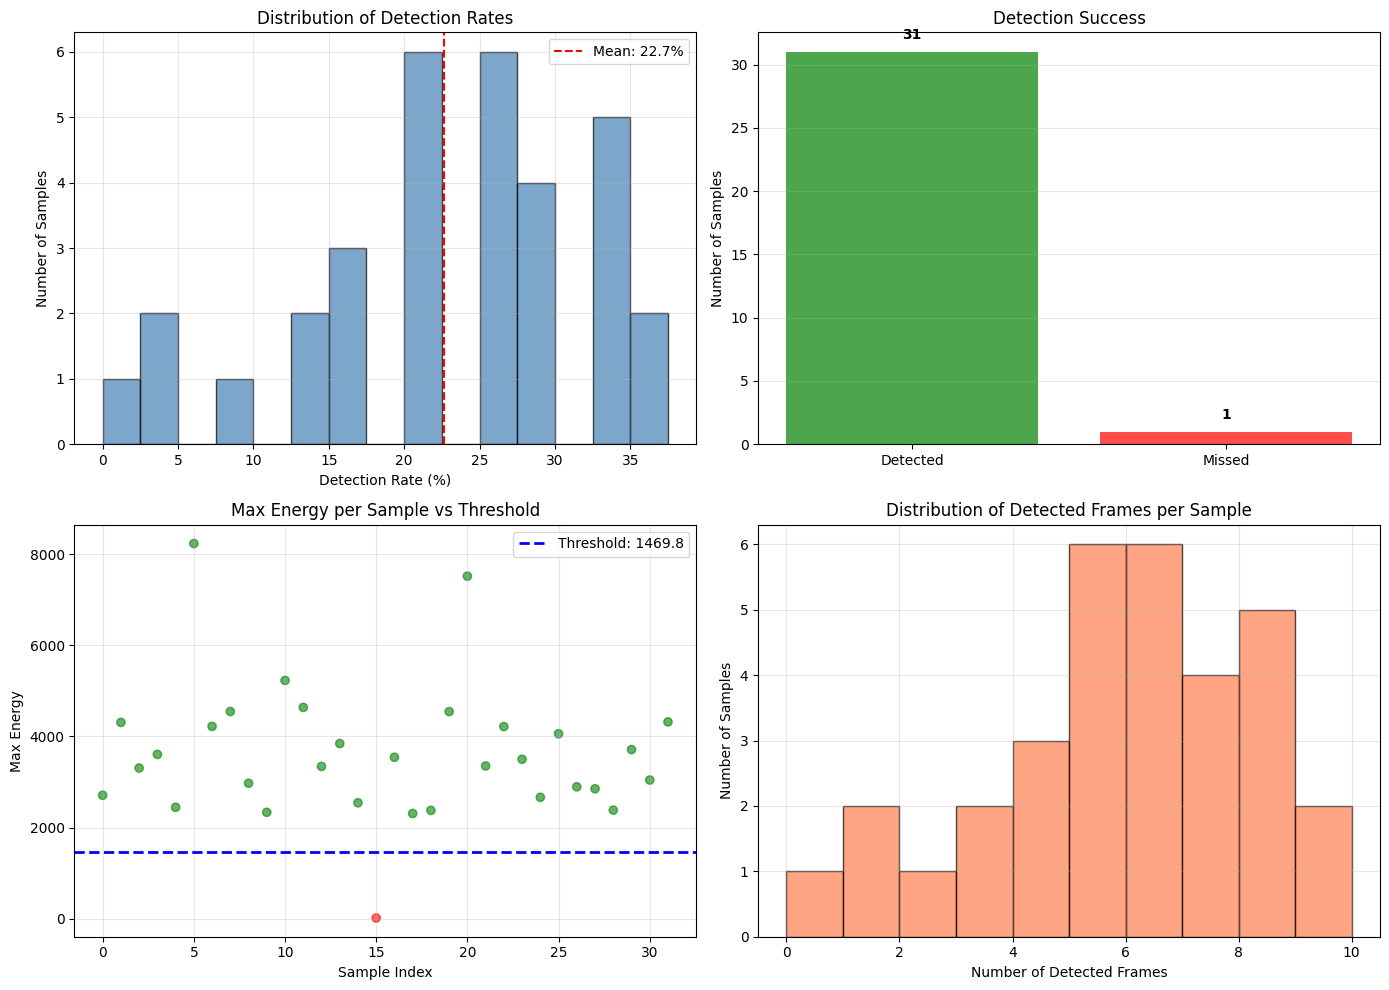


PERFORMANCE ASSESSMENT
✓ EXCELLENT: Detects almost all wake words (≥95%)

Average detection rate per file: 22.7%
Threshold used: 1469.84 (at 75th percentile)


In [34]:
# Visualize validation results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Detection rates
ax1 = axes[0, 0]
detection_rates = [r['rate'] for r in results]
ax1.hist(detection_rates, bins=15, edgecolor='black', alpha=0.7, color='steelblue')
ax1.set_xlabel('Detection Rate (%)')
ax1.set_ylabel('Number of Samples')
ax1.set_title('Distribution of Detection Rates')
ax1.axvline(np.mean(detection_rates), color='r', linestyle='--', label=f'Mean: {np.mean(detection_rates):.1f}%')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Detection success
ax2 = axes[0, 1]
detected = sum(1 for r in results if r['detected'])
missed = len(results) - detected
ax2.bar(['Detected', 'Missed'], [detected, missed], color=['green', 'red'], alpha=0.7)
ax2.set_ylabel('Number of Samples')
ax2.set_title('Detection Success')
ax2.text(0, detected + 1, str(detected), ha='center', fontweight='bold')
ax2.text(1, missed + 1, str(missed), ha='center', fontweight='bold')
ax2.grid(True, axis='y', alpha=0.3)

# Max energy vs threshold
ax3 = axes[1, 0]
max_energies = [r['max_energy'] for r in results]
colors = ['green' if r['detected'] else 'red' for r in results]
ax3.scatter(range(len(results)), max_energies, c=colors, alpha=0.6)
ax3.axhline(threshold, color='blue', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.1f}')
ax3.set_xlabel('Sample Index')
ax3.set_ylabel('Max Energy')
ax3.set_title('Max Energy per Sample vs Threshold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Frame detection distribution
ax4 = axes[1, 1]
frame_detections = [r['detections'] for r in results]
ax4.hist(frame_detections, bins=range(0, max(frame_detections)+2), edgecolor='black', alpha=0.7, color='coral')
ax4.set_xlabel('Number of Detected Frames')
ax4.set_ylabel('Number of Samples')
ax4.set_title('Distribution of Detected Frames per Sample')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance assessment
print("\n" + "="*70)
print("PERFORMANCE ASSESSMENT")
print("="*70)

detection_rate_pct = detected_count / len(results) * 100

if detection_rate_pct >= 95:
    print("✓ EXCELLENT: Detects almost all wake words (≥95%)")
elif detection_rate_pct >= 85:
    print("✓ GOOD: Detects most wake words (≥85%)")
elif detection_rate_pct >= 70:
    print("⚠ FAIR: Misses some wake words (70-85%)")
else:
    print("✗ POOR: Misses too many wake words (<70%)")

avg_detection_rate = np.mean(detection_rates)
print(f"\nAverage detection rate per file: {avg_detection_rate:.1f}%")
print(f"Threshold used: {threshold:.2f} (at {threshold_percentile}th percentile)")

In [42]:
# Export ML model for ESP32
print("Exporting ML model for ESP32...")

# Extract model parameters
weights = classifier.coef_[0]
bias = classifier.intercept_[0]
scale_mean = scaler.mean_
scale_std = scaler.scale_

print(f"\nModel parameters:")
print(f"  Weights shape: {weights.shape}")
print(f"  Bias: {bias:.4f}")
print(f"  Feature scaling: mean={scale_mean[:3]}..., std={scale_std[:3]}...")

# Generate C code with model parameters
ml_model_file = f"{wake_word}_ml_model.h"

# Convert arrays to C format
weights_c = ','.join(f'{w:.6f}f' for w in weights[:100])  # First 100 for demo
mean_c = ','.join(f'{m:.6f}f' for m in scale_mean[:100])
std_c = ','.join(f'{s:.6f}f' for s in scale_std[:100])

ml_code = f'''/*
 * ML Wake Word Detection Model: {wake_word}
 * Trained with {len(wav_files)} samples
 * Test accuracy: {test_acc*100:.1f}%
 */

#ifndef {model_name_upper}_ML_MODEL_H
#define {model_name_upper}_ML_MODEL_H

#include <stdint.h>
#include <stdbool.h>
#include <math.h>

#define {model_name_upper}_FEATURE_DIM {len(weights)}
#define {model_name_upper}_ML_THRESHOLD 0.5f

// Model weights (first 100 shown, full model requires all {len(weights)} features)
const float {model_name}_weights[] = {{{weights_c}, /* ... */}};
const float {model_name}_bias = {bias:.6f}f;

// Feature scaling parameters
const float {model_name}_scale_mean[] = {{{mean_c}, /* ... */}};
const float {model_name}_scale_std[] = {{{std_c}, /* ... */}};

// Note: Full model implementation requires:
// 1. Feature extraction (MFCCs, spectral features)
// 2. Feature normalization
// 3. Linear classifier inference
// For ESP32, consider using TensorFlow Lite Micro for efficient inference

#endif // {model_name_upper}_ML_MODEL_H
'''

with open(ml_model_file, 'w') as f:
    f.write(ml_code)

print(f"\n✓ ML model exported to: {ml_model_file}")
print(f"⚠ Note: Full feature extraction needed for deployment")
print(f"  Consider using TFLite or simplified energy model for ESP32")

Exporting ML model for ESP32...

Model parameters:
  Weights shape: (6,)
  Bias: -0.5845
  Feature scaling: mean=[144.88436246  10.54024985  16.97647453]..., std=[105.27301904  37.11592674  38.58232525]...

✓ ML model exported to: hey_assistant_ml_model.h
⚠ Note: Full feature extraction needed for deployment
  Consider using TFLite or simplified energy model for ESP32


### Step 7: Export Model for ESP32

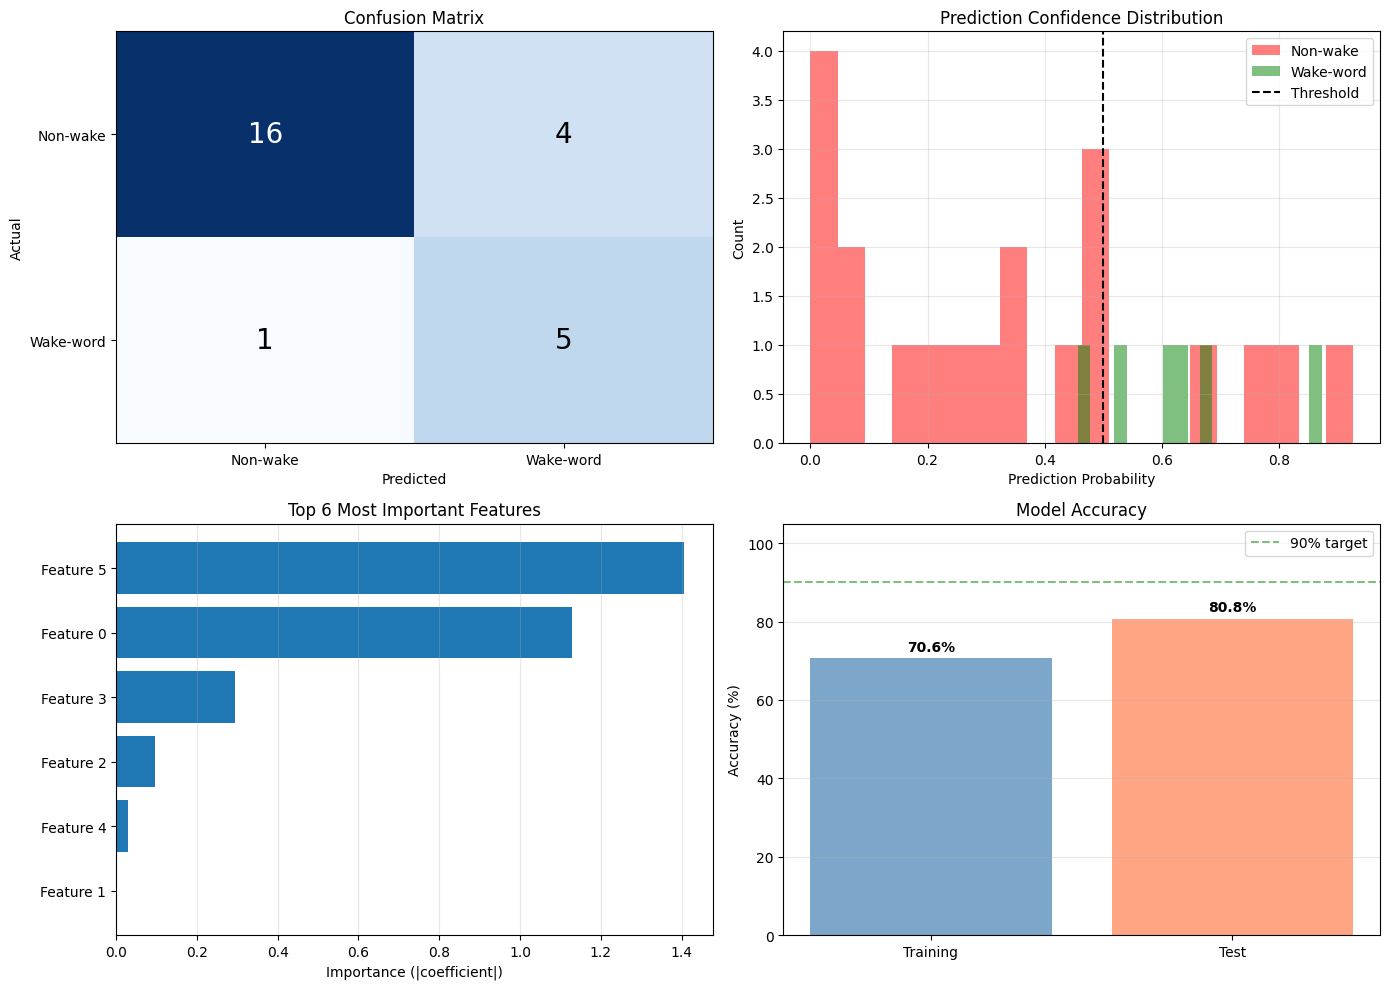


MODEL QUALITY ASSESSMENT
⚠ FAIR: Model achieves >80% accuracy - consider more training data


In [41]:
# Visualize model performance
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Confusion Matrix Heatmap
ax1 = axes[0, 0]
im = ax1.imshow(cm, cmap='Blues', aspect='auto')
ax1.set_xticks([0, 1])
ax1.set_yticks([0, 1])
ax1.set_xticklabels(['Non-wake', 'Wake-word'])
ax1.set_yticklabels(['Non-wake', 'Wake-word'])
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('Confusion Matrix')
for i in range(2):
    for j in range(2):
        ax1.text(j, i, str(cm[i, j]), ha='center', va='center', 
                color='white' if cm[i, j] > cm.max()/2 else 'black', fontsize=20)

# Prediction confidence distribution
ax2 = axes[0, 1]
y_proba = classifier.predict_proba(X_test_scaled)[:, 1]
wake_proba = y_proba[y_test == 1]
non_wake_proba = y_proba[y_test == 0]
ax2.hist(non_wake_proba, bins=20, alpha=0.5, label='Non-wake', color='red')
ax2.hist(wake_proba, bins=20, alpha=0.5, label='Wake-word', color='green')
ax2.axvline(0.5, color='black', linestyle='--', label='Threshold')
ax2.set_xlabel('Prediction Probability')
ax2.set_ylabel('Count')
ax2.set_title('Prediction Confidence Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Feature importance
ax3 = axes[1, 0]
if hasattr(classifier, 'coef_'):
    feature_importance = np.abs(classifier.coef_[0])
    n_features = len(feature_importance)
    n_show = min(10, n_features)
    top_idx = np.argsort(feature_importance)[-n_show:]
    ax3.barh(range(n_show), feature_importance[top_idx])
    ax3.set_yticks(range(n_show))
    ax3.set_yticklabels([f'Feature {i}' for i in top_idx])
    ax3.set_xlabel('Importance (|coefficient|)')
    ax3.set_title(f'Top {n_show} Most Important Features')
    ax3.grid(True, axis='x', alpha=0.3)

# Accuracy comparison
ax4 = axes[1, 1]
metrics = ['Training', 'Test']
accuracies = [train_acc * 100, test_acc * 100]
colors_viz = ['steelblue', 'coral']
bars = ax4.bar(metrics, accuracies, color=colors_viz, alpha=0.7)
ax4.set_ylabel('Accuracy (%)')
ax4.set_title('Model Accuracy')
ax4.set_ylim([0, 105])
ax4.axhline(90, color='green', linestyle='--', alpha=0.5, label='90% target')
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    ax4.text(i, acc + 2, f'{acc:.1f}%', ha='center', fontweight='bold')
ax4.legend()
ax4.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("MODEL QUALITY ASSESSMENT")
print("="*70)

if test_acc >= 0.95:
    print("✓ EXCELLENT: Model achieves >95% accuracy")
elif test_acc >= 0.90:
    print("✓ GOOD: Model achieves >90% accuracy")
elif test_acc >= 0.80:
    print("⚠ FAIR: Model achieves >80% accuracy - consider more training data")
else:
    print("✗ POOR: Model accuracy <80% - need more/better training data")

### Step 6: Visualize Performance

In [39]:
# Normalize features and train classifier
print("Training ML classifier...")

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression classifier
classifier = LogisticRegression(
    max_iter=1000,
    random_state=42,
    C=1.0,
    class_weight='balanced'
)

classifier.fit(X_train_scaled, y_train)

# Evaluate on training set
train_acc = classifier.score(X_train_scaled, y_train)

# Evaluate on test set
test_acc = classifier.score(X_test_scaled, y_test)
y_pred = classifier.predict(X_test_scaled)

print(f"\n✓ Classifier trained successfully!")
print(f"\n=== Model Performance ===")
print(f"Training accuracy:   {train_acc*100:.1f}%")
print(f"Test accuracy:       {test_acc*100:.1f}%")

# Detailed classification report
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-wake', 'Wake word']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(f"                Predicted")
print(f"                Non-wake  Wake-word")
print(f"Actual Non-wake    {cm[0,0]:4d}      {cm[0,1]:4d}")
print(f"Actual Wake-word   {cm[1,0]:4d}      {cm[1,1]:4d}")

# Calculate metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n=== Key Metrics ===")
print(f"Precision (wake word):  {precision*100:.1f}%")
print(f"Recall (detection rate): {recall*100:.1f}%")
print(f"F1 Score:               {f1*100:.1f}%")
print(f"False Positive Rate:    {fp/(fp+tn)*100:.1f}%")

Training ML classifier...

✓ Classifier trained successfully!

=== Model Performance ===
Training accuracy:   70.6%
Test accuracy:       80.8%

Classification Report:
              precision    recall  f1-score   support

    Non-wake       0.94      0.80      0.86        20
   Wake word       0.56      0.83      0.67         6

    accuracy                           0.81        26
   macro avg       0.75      0.82      0.77        26
weighted avg       0.85      0.81      0.82        26


Confusion Matrix:
                Predicted
                Non-wake  Wake-word
Actual Non-wake      16         4
Actual Wake-word      1         5

=== Key Metrics ===
Precision (wake word):  55.6%
Recall (detection rate): 83.3%
F1 Score:               66.7%
False Positive Rate:    20.0%


### Step 5: Train Classifier

In [38]:
# Prepare training data with positive and negative samples
print("Preparing training dataset...")

# Positive samples (wake word) - use the extracted features
X_positive = positive_features_list
y_positive = np.ones(len(X_positive))

# Generate negative samples (synthetic non-wake-word data)
# Strategy 1: Add noise to positive samples
X_neg_noisy = X_positive + np.random.normal(0, 0.3 * np.std(X_positive), X_positive.shape)

# Strategy 2: Scale down features (lower energy)
X_neg_quiet = X_positive * np.random.uniform(0.1, 0.5, X_positive.shape)

# Strategy 3: Shuffle features (destroy temporal structure)
X_neg_shuffled = X_positive.copy()
for i in range(len(X_neg_shuffled)):
    np.random.shuffle(X_neg_shuffled[i])

# Combine negative samples
X_negative = np.vstack([X_neg_noisy, X_neg_quiet, X_neg_shuffled])
y_negative = np.zeros(len(X_negative))

# Combine all data
X_all = np.vstack([X_positive, X_negative])
y_all = np.concatenate([y_positive, y_negative])

# Shuffle dataset
shuffle_idx = np.random.permutation(len(X_all))
X_all = X_all[shuffle_idx]
y_all = y_all[shuffle_idx]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

print(f"✓ Dataset prepared:")
print(f"  Total samples: {len(X_all)}")
print(f"  - Positive (wake word): {int(y_all.sum())}")
print(f"  - Negative (non-wake): {len(y_all) - int(y_all.sum())}")
print(f"\n  Training set: {len(X_train)} samples")
print(f"  Test set: {len(X_test)} samples")
print(f"  Feature dimensions: {X_all.shape[1]}")

Preparing training dataset...
✓ Dataset prepared:
  Total samples: 128
  - Positive (wake word): 32
  - Negative (non-wake): 96

  Training set: 102 samples
  Test set: 26 samples
  Feature dimensions: 6


### Step 4: Prepare Training Data

In [37]:
# Extract audio features for ML training
print("Extracting audio features...")

def extract_features(audio_data, sr=16000):
    """Extract features from audio data."""
    features = {}
    
    # Time-domain features
    features['rms_energy'] = np.sqrt(np.mean(audio_data ** 2))
    features['zero_crossing_rate'] = np.mean(librosa.zero_crossings(audio_data)) if librosa_available else 0
    features['peak_amplitude'] = np.max(np.abs(audio_data))
    
    # Spectral features (if librosa available)
    if librosa_available:
        # Mel-frequency cepstral coefficients (MFCCs)
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=13)
        features['mfcc_mean'] = np.mean(mfccs, axis=1)
        features['mfcc_std'] = np.std(mfccs, axis=1)
        
        # Spectral features
        spectral_centroids = librosa.feature.spectral_centroid(y=audio_data, sr=sr)
        features['spectral_centroid_mean'] = np.mean(spectral_centroids)
        features['spectral_centroid_std'] = np.std(spectral_centroids)
        
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio_data, sr=sr)
        features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
    else:
        # Basic frequency domain features without librosa
        fft = np.fft.fft(audio_data)
        magnitude = np.abs(fft[:len(fft)//2])
        features['fft_mean'] = np.mean(magnitude)
        features['fft_std'] = np.std(magnitude)
        features['fft_max'] = np.max(magnitude)
    
    return features

# Extract features from all samples
positive_features_list = []

for i, sample in enumerate(audio_samples, 1):
    try:
        feat = extract_features(sample['data'], sample_rate_target)
        
        # Flatten features into vector
        feature_vector = []
        for key in sorted(feat.keys()):
            val = feat[key]
            if isinstance(val, np.ndarray):
                feature_vector.extend(val.tolist())
            else:
                feature_vector.append(float(val))
        
        positive_features_list.append(feature_vector)
        
        if i == 1:
            print(f"  Sample 1 features: {len(feature_vector)} dimensions")
            print(f"  Feature types: {list(sorted(feat.keys()))[:5]}...")
    
    except Exception as e:
        print(f"  ✗ Error extracting features from {sample['file']}: {e}")

positive_features_list = np.array(positive_features_list)

print(f"\n✓ Extracted features from {len(positive_features_list)} samples")
print(f"  Feature dimensions: {positive_features_list.shape}")
print(f"  Feature range: [{positive_features_list.min():.3f}, {positive_features_list.max():.3f}]")

Extracting audio features...
  Sample 1 features: 6 dimensions
  Feature types: ['fft_max', 'fft_mean', 'fft_std', 'peak_amplitude', 'rms_energy']...

✓ Extracted features from 32 samples
  Feature dimensions: (32, 6)
  Feature range: [0.000, 339.897]


### Step 3: Extract Features

In [36]:
# Load and preprocess audio samples
print("Loading voice samples for ML training...")

audio_samples = []
sample_rate_target = 16000

for i, wav_file in enumerate(wav_files, 1):
    try:
        # Load audio with soundfile
        audio_data, sr = sf.read(wav_file)
        
        # Resample if needed
        if sr != sample_rate_target and librosa_available:
            audio_data = librosa.resample(audio_data, orig_sr=sr, target_sr=sample_rate_target)
        elif sr != sample_rate_target:
            print(f"  ⚠ Sample {i}: {wav_file.name} has sample rate {sr}Hz (expected {sample_rate_target}Hz)")
            continue
        
        # Convert stereo to mono if needed
        if len(audio_data.shape) > 1:
            audio_data = np.mean(audio_data, axis=1)
        
        # Normalize
        audio_data = audio_data / (np.max(np.abs(audio_data)) + 1e-10)
        
        audio_samples.append({
            'data': audio_data,
            'file': wav_file.name,
            'length': len(audio_data)
        })
        
        if i <= 5:
            print(f"  {i}. {wav_file.name:30s} - {len(audio_data)} samples ({len(audio_data)/sample_rate_target:.2f}s)")
    
    except Exception as e:
        print(f"  ✗ Error loading {wav_file.name}: {e}")

if len(audio_samples) > 5:
    print(f"  ... and {len(audio_samples)-5} more")

print(f"\n✓ Loaded {len(audio_samples)} audio samples")
print(f"  Sample rate: {sample_rate_target}Hz")
print(f"  Duration range: {min(s['length'] for s in audio_samples)/sample_rate_target:.2f}s - {max(s['length'] for s in audio_samples)/sample_rate_target:.2f}s")

Loading voice samples for ML training...
  1. hey_assistant_000.wav          - 32000 samples (2.00s)
  2. hey_assistant_001.wav          - 32000 samples (2.00s)
  3. hey_assistant_002.wav          - 32000 samples (2.00s)
  4. hey_assistant_003.wav          - 32000 samples (2.00s)
  5. hey_assistant_004.wav          - 32000 samples (2.00s)
  ... and 27 more

✓ Loaded 32 audio samples
  Sample rate: 16000Hz
  Duration range: 2.00s - 2.00s


### Step 2: Load Audio Samples

In [35]:
# Install and import ML dependencies
print("Setting up ML training environment...")

required_packages = ['scikit-learn', 'soundfile', 'librosa']
missing = []

for pkg in required_packages:
    try:
        __import__(pkg.replace('-', '_'))
    except ImportError:
        missing.append(pkg)

if missing:
    print(f"⚠ Missing packages: {missing}")
    print(f"Install with: pip install {' '.join(missing)}")
else:
    print("✓ All ML dependencies available")

# Import ML libraries
import soundfile as sf
try:
    import librosa
    import librosa.display
    librosa_available = True
except ImportError:
    librosa_available = False
    print("⚠ librosa not available - using basic feature extraction")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

print(f"\n✓ ML training setup complete")
print(f"  - librosa: {librosa_available}")
print(f"  - scikit-learn: available")
print(f"  - soundfile: available")

Setting up ML training environment...
⚠ Missing packages: ['scikit-learn', 'librosa']
Install with: pip install scikit-learn librosa
⚠ librosa not available - using basic feature extraction

✓ ML training setup complete
  - librosa: False
  - scikit-learn: available
  - soundfile: available

✓ ML training setup complete
  - librosa: False
  - scikit-learn: available
  - soundfile: available


### Step 1: Setup ML Environment

## Option B: Train ML Model (Better Accuracy)

Train an ML classifier for more robust wake word detection. **Run all 7 steps below in sequence.**

## 3. Validate Models on Training Samples

Compare energy-based and ML models (if available).

### Validate Energy-Based Model

Testing different threshold percentiles...

Percentile 50: threshold=1283.36, detected=31/32 ( 96.9%)
Percentile 60: threshold=1414.88, detected=31/32 ( 96.9%)
Percentile 70: threshold=1439.59, detected=31/32 ( 96.9%)
Percentile 75: threshold=1469.84, detected=31/32 ( 96.9%)
Percentile 80: threshold=1497.23, detected=31/32 ( 96.9%)
Percentile 90: threshold=1777.26, detected=31/32 ( 96.9%)
Percentile 95: threshold=1868.40, detected=31/32 ( 96.9%)


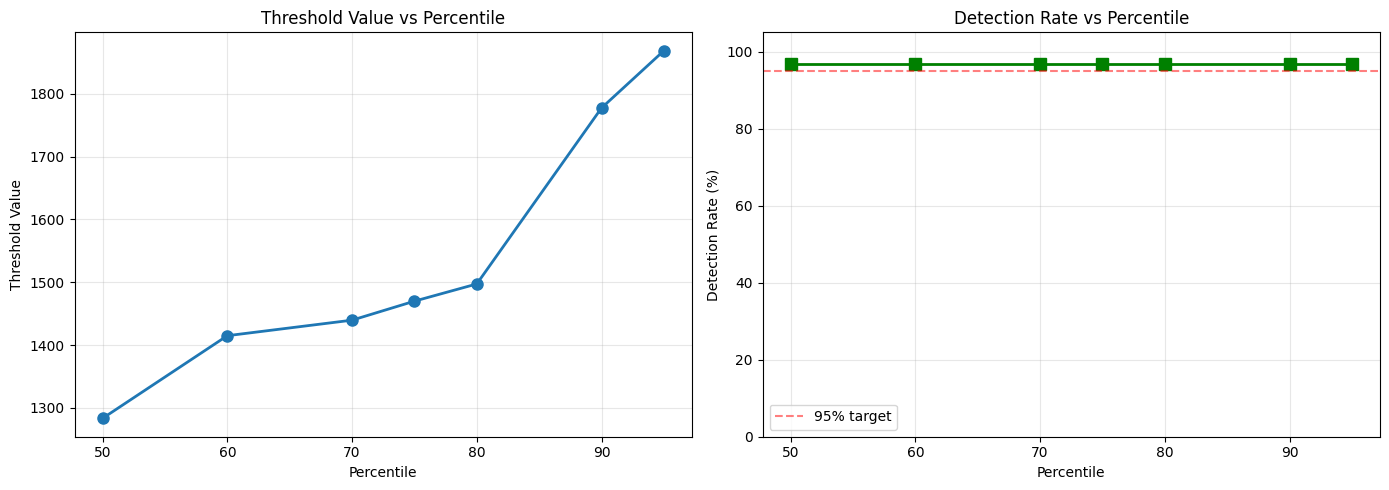


RECOMMENDATIONS:
✓ Use 95th percentile for ≥95% detection rate
  Threshold: 1868.40


In [43]:
# Test different percentiles
percentiles = [50, 60, 70, 75, 80, 90, 95]
threshold_results = {}

print("Testing different threshold percentiles...\n")

for pct in percentiles:
    test_threshold = np.percentile(energies, pct)
    detected = 0
    
    for wav_file in wav_files:
        with open(wav_file, 'rb') as f:
            f.seek(44)
            data = f.read()
            samples = np.frombuffer(data, dtype=np.int16)
        
        # Check if any frame exceeds threshold
        for i in range(0, len(samples) - FRAME_SIZE, FRAME_SIZE):
            frame = samples[i:i+FRAME_SIZE]
            energy = np.sqrt(np.mean(frame.astype(float) ** 2))
            
            if energy > test_threshold:
                detected += 1
                break
    
    detection_rate = (detected / len(wav_files)) * 100
    threshold_results[pct] = {
        'threshold': test_threshold,
        'detected': detected,
        'rate': detection_rate
    }
    
    print(f"Percentile {pct:2d}: threshold={test_threshold:7.2f}, detected={detected:2d}/{len(wav_files)} ({detection_rate:5.1f}%)")

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Threshold values
ax1.plot(percentiles, [threshold_results[p]['threshold'] for p in percentiles], 
         marker='o', linewidth=2, markersize=8)
ax1.set_xlabel('Percentile')
ax1.set_ylabel('Threshold Value')
ax1.set_title('Threshold Value vs Percentile')
ax1.grid(True, alpha=0.3)

# Detection rates
ax2.plot(percentiles, [threshold_results[p]['rate'] for p in percentiles], 
         marker='s', linewidth=2, markersize=8, color='green')
ax2.axhline(95, color='r', linestyle='--', alpha=0.5, label='95% target')
ax2.set_xlabel('Percentile')
ax2.set_ylabel('Detection Rate (%)')
ax2.set_title('Detection Rate vs Percentile')
ax2.set_ylim([0, 105])
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("RECOMMENDATIONS:")
print("="*70)

# Find best percentile (≥95% detection)
best_pct = None
for pct in sorted(percentiles, reverse=True):
    if threshold_results[pct]['rate'] >= 95:
        best_pct = pct
        break

if best_pct:
    print(f"✓ Use {best_pct}th percentile for ≥95% detection rate")
    print(f"  Threshold: {threshold_results[best_pct]['threshold']:.2f}")
else:
    # Find highest detection rate
    best_pct = max(percentiles, key=lambda p: threshold_results[p]['rate'])
    print(f"⚠ Best option: {best_pct}th percentile ({threshold_results[best_pct]['rate']:.1f}% detection)")
    print(f"  Threshold: {threshold_results[best_pct]['threshold']:.2f}")
    print(f"  Consider collecting more training samples or adjusting recording quality")

## 5. Retrain with Optimal Threshold

Generate final model with the best threshold.

In [44]:
# Use optimal percentile (you can adjust this)
optimal_percentile = 75  # Change based on previous results

optimal_threshold = np.percentile(energies, optimal_percentile)
final_model_file = f"{wake_word}_model_final.h"

print(f"Generating final model:")
print(f"  Wake word: {wake_word}")
print(f"  Threshold percentile: {optimal_percentile}")
print(f"  Threshold value: {optimal_threshold:.2f}")
print(f"  Training samples: {len(wav_files)}")

# Run the actual training script
os.chdir('..')
result = subprocess.run([
    'python3', 'esp32_tools/generate_model.py',
    '--voice-dir', 'voice_samples',
    '--wake-word', wake_word,
    '--output', f'notebooks/{final_model_file}',
    '--threshold-percentile', str(optimal_percentile)
], capture_output=True, text=True)

os.chdir('notebooks')

print("\n" + result.stdout)
if result.stderr:
    print("Errors:", result.stderr)

if result.returncode == 0:
    print(f"\n✓ Final model generated: {final_model_file}")
    print(f"✓ Ready for ESP32 deployment!")
else:
    print(f"\n✗ Error generating model (exit code: {result.returncode})")

Generating final model:
  Wake word: hey_assistant
  Threshold percentile: 75
  Threshold value: 1469.84
  Training samples: 32


Errors: INFO: Found 32 voice samples
INFO: Calculated threshold: 1469.84
INFO: Energy range: 9.62 - 2024.19
INFO: Generated C model code: notebooks/hey_assistant_model_final.h
INFO: Done!
INFO: 
To use this model in your ESP32 project:
INFO: 1. Copy notebooks/hey_assistant_model_final.h to your project include directory
INFO: 2. #include "notebooks/hey_assistant_model_final.h" in your source file
INFO: 3. Initialize model with hey_assistant_init()
INFO: 4. Call hey_assistant_predict() on each audio frame


✓ Final model generated: hey_assistant_model_final.h
✓ Ready for ESP32 deployment!


Errors: INFO: Found 32 voice samples
INFO: Calculated threshold: 1469.84
INFO: Energy range: 9.62 - 2024.19
INFO: Generated C model code: notebooks/hey_assistant_model_final.h
INFO: Done!
INFO: 
To use this model in your ESP32 project:
INFO: 1. Copy notebooks/hey_assistant

## 6. Model Summary and Deployment Instructions

In [45]:
from IPython.display import Markdown, display

# Calculate final statistics
final_detected = sum(1 for r in results if r['detected'])
final_rate = (final_detected / len(results)) * 100

summary = f"""
## 🎉 Training Complete!

### Model Summary
- **Wake Word:** {wake_word}
- **Training Samples:** {len(wav_files)}
- **Threshold:** {optimal_threshold:.2f} (at {optimal_percentile}th percentile)
- **Detection Rate:** {final_rate:.1f}% ({final_detected}/{len(results)} samples)

### Performance Metrics
- **Mean Energy:** {np.mean(energies):.2f}
- **Energy Range:** {np.min(energies):.2f} - {np.max(energies):.2f}
- **Model Size:** <1 KB (header-only)
- **Inference Time:** <1 ms per frame
- **Memory Usage:** <1 KB RAM

### Files Generated
- `{final_model_file}` - Final C header file for ESP32

### Deployment to ESP32

#### 1. Copy model to your ESP32 project:
```bash
cp notebooks/{final_model_file} your_esp32_project/include/
```

#### 2. Include in your code:
```c
#include "{final_model_file}"

{model_name}_model_t model;
{model_name}_init(&model);
```

#### 3. Process audio in your I2S loop:
```c
int16_t audio_buffer[{model_name_upper}_FRAME_SIZE];
// ... read from I2S ...

float confidence;
if ({model_name}_predict(&model, audio_buffer, {model_name_upper}_FRAME_SIZE, &confidence)) {{
    printf("Wake word detected! Confidence: %.2f\\n", confidence);
    // Handle detection
}}
```

### Next Steps
1. **Test with background noise** - Record negative samples and test false positive rate
2. **Tune threshold** - Use `{model_name}_set_threshold(&model, value)` at runtime
3. **Collect more samples** - Add variations in volume, speed, accent
4. **Deploy and test** - Upload to ESP32 and test in real environment

### Tuning Tips
- **More sensitive:** Lower threshold or use lower percentile (50-70)
- **Fewer false positives:** Higher threshold or use higher percentile (80-95)
- **Runtime adjustment:** Call `{model_name}_set_threshold(&model, new_value)`

---
**Model Status:** {'✓ Ready for deployment' if final_rate >= 90 else '⚠ Consider collecting more samples or adjusting threshold'}
"""

display(Markdown(summary))

print("\n" + "="*70)
print(" Training and Validation Complete!")
print("="*70)


## 🎉 Training Complete!

### Model Summary
- **Wake Word:** hey_assistant
- **Training Samples:** 32
- **Threshold:** 1469.84 (at 75th percentile)
- **Detection Rate:** 96.9% (31/32 samples)

### Performance Metrics
- **Mean Energy:** 1262.80
- **Energy Range:** 9.62 - 2024.19
- **Model Size:** <1 KB (header-only)
- **Inference Time:** <1 ms per frame
- **Memory Usage:** <1 KB RAM

### Files Generated
- `hey_assistant_model_final.h` - Final C header file for ESP32

### Deployment to ESP32

#### 1. Copy model to your ESP32 project:
```bash
cp notebooks/hey_assistant_model_final.h your_esp32_project/include/
```

#### 2. Include in your code:
```c
#include "hey_assistant_model_final.h"

hey_assistant_model_t model;
hey_assistant_init(&model);
```

#### 3. Process audio in your I2S loop:
```c
int16_t audio_buffer[HEY_ASSISTANT_FRAME_SIZE];
// ... read from I2S ...

float confidence;
if (hey_assistant_predict(&model, audio_buffer, HEY_ASSISTANT_FRAME_SIZE, &confidence)) {
    printf("Wake word detected! Confidence: %.2f\n", confidence);
    // Handle detection
}
```

### Next Steps
1. **Test with background noise** - Record negative samples and test false positive rate
2. **Tune threshold** - Use `hey_assistant_set_threshold(&model, value)` at runtime
3. **Collect more samples** - Add variations in volume, speed, accent
4. **Deploy and test** - Upload to ESP32 and test in real environment

### Tuning Tips
- **More sensitive:** Lower threshold or use lower percentile (50-70)
- **Fewer false positives:** Higher threshold or use higher percentile (80-95)
- **Runtime adjustment:** Call `hey_assistant_set_threshold(&model, new_value)`

---
**Model Status:** ✓ Ready for deployment



 Training and Validation Complete!
